# 동시성 소켓 프로그래밍(Concurrent Socket Programming)

여러 가지 작업을 동시에 처리하는 프로그램을 동시성 프로그램이라 한다.  
동시성 소켓 프로그램이 왜 필요한가?  
서버가 클라이언트의 요청을 처리할 때  
* 서버가 연결된 클라이언트 요청을 모두 처리한 후에, 순차적으로 새로운 클라이언트의 요청을 처리하면 새 클라이언트의 대기 시간이 길어진다  
* 만약 클라이언트 요청이 입출력을 포함하면 처리 시간이 무한히 길어질 수 있다
* 어떤 클라이언트의 입출력을 기다리는 동안에 다른 클라이언트를 서비스하면 효율적인 서비스가 가능하다

## 서버 종류

**반복 서버(iterative server)**  
  * 클라이언트의 요청을 하나씩 서비스하는 서버
  * A가 서비스 받고 있는 동안에 B는 대기
  * A 서비스가 길어지면 B의 대기시간도 길어진다! 
    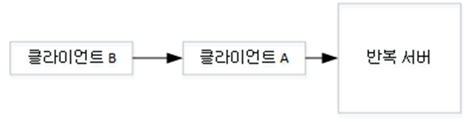

**병행 서버(concurrent server)**  
  * 다수의 클라이언트를 동시에 서비스하는 서버  
  * 병행 서버 구현 방법  
    * 스레드(Thread) 방식  
      * 클라이언트 마다 별도의 스레드 사용: 멀티스레드  
    * 이벤트 구동(Event driven) 방식  
      * 다른 작업을 진행하다가 소켓 관련 이벤트가 발생하면 이벤트를 처리하는 방식

**동시성 소켓 프로그램 구현 방법**
  * 멀티스레드 이용
  * select 모듈 이용
  * socketserver 모듈 이용
  * selectors 모듈 이용
  * asyncio 모듈 이용

## 멀티스레드 소켓 프로그래밍

**프로세스와 스레드**  
  * 컴퓨터에서 실행 중인 프로그램을 프로세스(process)라 하며
  * 대부분의 경우, 한 개의 프로그램은 한 개의 프로세스로 실행된다
  * 그러나 한 개의 프로세스는 한 개 이상의 스레드(thread)로 실행될 수 있다  
    

**스레드(thread)란?**
  * 프로그램 실행 단위이며 운영체제에 의해 시간이 배분되고 관리됨
  * 프로세스가 시작되면 메인 스레드가 자동 생성되어 실행된다
  * 프로세스는 메인 스레드 외에 여러 개의 스레드로 나누어 실행될 수 있다
    * 프로세스가 메인 스레드 하나로 실행될 경우, 블로킹(blocking) 함수를 호출하면 함수가 반환될 때까지 실행이 중지되므로 다른 부분을 실행할 수 없다
    * 두 개의 블로킹 함수를 별도의 스레드로 실행하면 적절히 시간 배분이 되어 함수가 모두 실행된다
  * 스레드 관리는 운영체제가 하므로 사용자 개입이 필요 없음

**서버 소켓 프로그램에서 스레드의 역할**  
  * 메인 스레드는 클라이언트를 연결하고 서브 스레드를 생성하여 클라이언트의 요청 처리(함수로 구현)을 서브 스레드에게 맡긴다
  * 서브 스레드는 배분된 시간 동안에 할당된 함수를 실행한다
  * 소켓 프로그램은 외부 입출력(데이터 송수신)을 포함하므로 프로그램 실행이 블로킹 될 수 있지만, 데이터 송수신 부분을 다른 스레드로 실행하면 전체 프로세스가 블로킹 되지는 않는다
  
  <멀티스레드에 의한 소켓 프로그램의 실행>  
  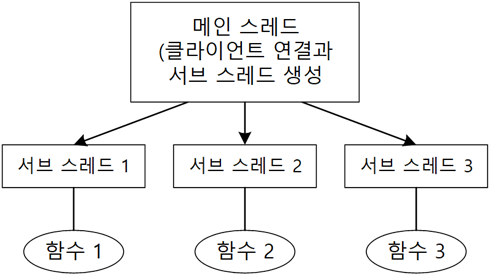

**네트워크 프로그램에서 각 스레드의 역할**  

  <멀티스레드를 이용한 네트워크 프로그램 순서>  
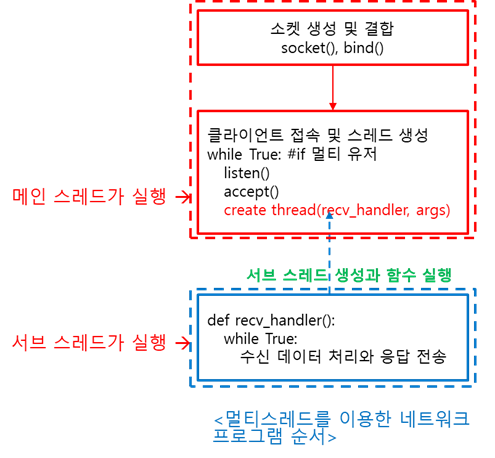

**멀티스레드 구현 방법**  
  * _thread 모듈 이용
  * threading.Thread 클래스 이용
  * threading.Thread의 파생 클래스 이용
  * concurrent.future 모듈 이용

### _thread 모듈을 이용한 멀티스레드 구현(생략)

* 프로그램을 실행하면 메인 스레드가 자동 실행되며, 메인 함수(main())를 실행한다
* 메인 스레드로 실행되는 main() 함수에서 _thread 모듈을 이용하여 서브 스레드를 생성하고 실행한다(fork)
* 서브 스레드 생성과 실행
  * _thread.start_new_thread(handler 함수, (arguments)) 함수로 스레드를 생성하고 실행한다
    * handler 함수 : 서브 스레드로 실행할 함수
    * (arguments) : 함수로 전달할 인수

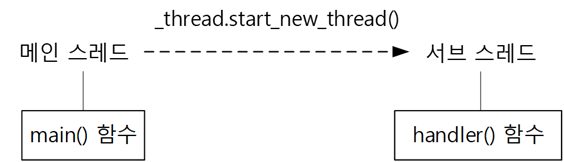

* handler() 함수  
  * 서브 스레드로 실행되며 클라이언트 메시지를 수신하여 처리한다


#### _thread를 이용한 TCP 서버
메시지를 수신하여 출력하고 응답을 클라이언트에게 보낸다  
클라이언트 연결은 메인 함수에서 실행하고 메시지 송수신은 handler() 함수에서 처리하고 이 함수는 서브 스레드가 실행한다

+ 서브 스레드 작업  
```python
def handler(clientsock, addr):
  while True:
    #데이터 수신 및 출력  
    #응답 전송
```

+ 메인 스레드 작업  
```python  
if __name__ == “__main__”:  
  # socket을 생성(serversock)하고 클라이언트 접속 대기
  serversock = socket.socket()
  serversock.listen(5)  

  while True:
	clientsock, addr = serversock.accept()
        # 서브 스레드 생성 실행
    	_thread.start_new_thread(handler, (clientsock, addr))
```

In [ ]:
# thread_TCP_server.py
# _thread를 이용한 TCP 서버 프로그램

from socket import *
import _thread

BUFFSIZE = 1024
host_addr = ''
port = 2500

In [ ]:
#클라이언트에게 보낼 응답 메시지
def response(key):
    return '서버 응답 메시지 ' + str(key)

#서브 스레드로 실행할 함수
# 데이터를 수신하여 출력하고, 응답을 전송한다
def handler(clientsock, addr):
    count = 1 # 메시지 번호
    while True:
        #수신 데이터 화면 출력
        data = clientsock.recv(BUFFSIZE)
        print('data:' + repr(data)) 
        
        #연결이 종료되었으면 통신을 중단한다
        if not data: break
        
        #응답 전송
        clientsock.send(response(count).encode()) 
        print('sent:' + repr(response(count)))
        count += 1

In [ ]:
#메인스레드로 실행되는 main() 함수
if __name__=='__main__':
    ADDR = (host_addr, port)
    #TCP 소켓 생성
    serversock = socket(AF_INET, SOCK_STREAM)
    
    #주소 재사용 옵션 설정
    serversock.setsockopt(SOL_SOCKET, SO_REUSEADDR, 1) #SO_REUSEADDR 의 옵션 값을 TRUE로 설정
    serversock.bind(ADDR)
    serversock.listen(5)
    
    #클라이언트 연결 요청을 수락하고 서브스레드를 생성하고 실행한다
    while True:
        print('waiting for connection...')
        #연결 수락
        clientsock, addr = serversock.accept()
        print('...connected from:', addr)
        
        #서브스레드가 실행할 함수를 지정하고 서브스레드를 실행한다 
        _thread.start_new_thread(handler, (clientsock, addr))

**[실행 방법]**  
thread_TCP_server.py를 먼저 실행하고 VS Code에서 TCP_client.py를 두 번 실행한다. 두 클라이언트 메시지에 대해 각각 응답이 수신되는지 확인한다.

**[연습문제 12-1]**  
앞에서 살펴본 서버 프로그램은 클라이언트의 메시지를 출력하고 응답 메시지를 전송한다. 준비된 메시지를 전송하는 대신 키보드에서 메시지를 입력받아 전송하도록 서버 프로그램을 수정해 보자.  
키보드로부터 메시지를 입력하여 전송하는 write_handle(clientsock. addr) 함수를 정의하고 이 함수를 스레드로 실행하도록 한다. 따라서 두 개의 스레드가 실행되므로 클라이언트에서 메시지가 수신되면 화면에 출력하고, 키보드에서 메시지가 입력되면 클라이언트로 전송하도록 프로그램을 수정하시오. 

### threading 모듈을 이용한 멀티스레드 프로그래밍

1. threading.Thread 클래스의 객체를 정의하고 스레드를 실행하는 방법  
```python
object = threading.Thread(target=함수, args=(인수))
object.start()
```
2. threading.Thread 클래스의 파생 클래스를 정의하고 run() 메서드를 재정의 하는 방법  
   run() 메서드는 파생 클래스 객체의 start() 메서드를 호출하면 자동 실행된다
```python
class subclass(threading.Thread):
    def __init__():
    def run():
th = subclass()
th.start()
```


#### threading 모듈 사용한 TCP 채팅 서버 프로그램
채팅 서버 프로그램은 수신된 클라이언트 메시지를 다른 모든 클라이언트에게 전송한다. 따라서 모든 클라이언트가 동일한 메시지를 받게 된다.

**메인 함수** 
  + 클라이언트의 연결 요청을 수락
  + 연결된 클라이언트를 연결 목록에 추가
  + 송수신 데이터를 처리하는 handler() 함수를 서브스레드로 실행

**handler() 함수**  
  + 수신 데이터를 다른 클라이언트에게 전송
  + 연결이 해제된 클라이언트는 연결 목록에서 제외

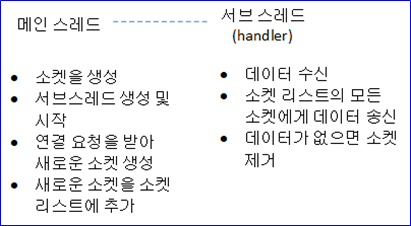

In [ ]:
#threading_server.py
#threading 모듈을 이용한 TCP 채팅 서버 프로그램

import socket
import threading

#데이터를 수신하여 모든 클라이언트에게 다시 전송하는 함수
#연결이 종료된 소켓은 연결 소켓 목록에서 제거
def handler(c, a): #c: 소켓, a: 주소 
    global connections # 연결 소켓 목록
    
    while True:
        #데이터 수신
        data = c.recv(1024)
        
        #연결된 모든 상대방에게 데이터 전송
        for connection in connections:
            connection.send(data)
            
            #데이터가 없으면 연결이 종료된 것이므로 연결 목록에서 제거
            if not data: 
                connections.remove(c)
                c.close()
                break

In [ ]:
# 메인 함수
sock = socket.socket(socket.AF_INET, socket.SOCK_STREAM)
sock.bind(("", 2500))
sock.listen(1)

#서버와 연결된 클라이언트 목록
connections = [] 
print("Waiting for clients")

#연결 요청을 수락하고 데이터 송수신을 서브스레드로 실행
while True:
    c, a = sock.accept()
    
    #스레드 객체를 생성하고 실행
    cThread = threading.Thread(target=handler, args=(c,a))
    cThread.daemon = True #서브스레드가 종료되면 메인 스레드도 종료
    cThread.start()
    
    # 새 클라이언트를 목록에 추가
    connections.append(c) 
    print("연결된 클라이언트: ",connections)

**[실행 방법]**  
threading_server.py를 먼저 실행하고, TCP_client.py(클라이언트)를 두 번 이상 실행한다. 한 클라이언트가 메시지를 송신하면 다른 모든 클라이언트가 수신하는지 확인한다

**[연습문제 12-2]**  
TCP_client.py는 프로그램을 순차적으로 실행하므로 메시지 송신이 끝나야 데이터가 수신된다. 클라이언트에서도 스레드를 이용하여 메시지가 수신되는 즉시 출력되는 프로그램을 작성하시오.

%load G:\파이썬교재\sources\book_codes\3판\solutions\연습문제_12-2_답안.py

#### threading.Thread의 서브 클래스를 이용한 TCP 에코 서버 프로그램

서브 클래스는 연결된 소켓으로부터 메시지를 받아 출력하고 이를 다시 클라이언트에게 전송  

* 서브 클래스 메서드
    * \__init\__()
    * run()  
      run() 메서드는 스레드객체.start()를 호출하면 실행된다

In [ ]:
#threading_class_echo_server.py
#threading class를 이용한 TCP 에코 서버 프로그램

import socket, threading

#threading.Thread의 서브 클래스
class ClientThread(threading.Thread):
    def __init__(self,clientAddress,clientsocket):
        #부모 클래스 초기화 함수 실행
        threading.Thread.__init__(self) 
        
        #인스턴수 변수 정의
        self.csocket = clientsocket 
        self.addr = clientAddress
        print ("New socket added: ", self.addr)

In [ ]:
    #thread_obj.start()로 실행되는 메서드
    def run(self):
        print ("Connection from : ", self.addr)
        msg = ''
        
        # 데이터를 수신하여 다시 상대방에게 전송(에코)
        while True:
            data = self.csocket.recv(2048) #데이터 수신
            msg = data.decode()
            
            # quit가 수신되면 종료
            if msg=='quit': 
              break
            
            print ("from client", msg)
            
            #수신 메시지 전송
            self.csocket.send(bytes(msg,'UTF-8')) #문자열을 UTF-8 포맷으로 변환
            
        print ("Client at ", self.addr , " disconnected...")

In [ ]:
LOCALHOST = ""
PORT = 2500

#서버 소켓 생성
server = socket.socket(socket.AF_INET, socket.SOCK_STREAM)
server.setsockopt(socket.SOL_SOCKET, socket.SO_REUSEADDR, 1)
server.bind((LOCALHOST, PORT))
print("Server started")
print("Waiting for client request..")
server.listen(5)

#클라이언트 마다 하나의 스레드가 배정된다
while True: 
    clientsock, clientAddress = server.accept()
    
    #스레드 객체 생성
    newthread = ClientThread(clientAddress, clientsock)
    #스레드 시작
    newthread.start()

**[실행 방법]**  
VS Code에서 threading_class_echo_server.py를 먼저 실행하고, TCP_client.py(클라이언트)를 실행한다. 클라이언트가 송신한 메시지를 다시 수신하는지 확인한다

#### threading 모듈을 이용한 GUI 서버/클라이언트 프로그램

클라이언트에서 섭씨온도를 서버로 전송하면 서버에서 화씨로 변환하여 전송하는 GUI(Graphic User Interface) 프로그램
+ 서버는 섭씨를 화씨로 변환하여 전송
+ 클라이언트 프로그램은 사용자가 섭씨온도를 입력하는 창과 화씨온도를 출력하는 창, 전송 버튼으로 구성

**서버 프로그램(콘솔 모드)**  

수신한 섭씨 온도를 float형으로 변환한 다음, 화씨온도를 계산하여 송신한다.

In [ ]:
#GUI_socket_server.py
# 섭씨 온도를 받아 화씨 온도로 변환하여 전송하는 TCP 서버 프로그램

import sys
from socket import *

ECHO_PORT = 2500
BUFSIZE = 1024
   
s = socket(AF_INET, SOCK_STREAM)
s.setsockopt(SOL_SOCKET, SO_REUSEADDR, 1)
s.bind(('', port))
s.listen(1)

#연결 요청 수락
print("Waiting for connection from client")
conn, (remotehost, remoteport) = s.accept()
print('connected by', remotehost, remoteport)

In [ ]:
while True:
    #데이터 수신
    data = conn.recv(BUFSIZE) 
    if not data: #연결이 종료되었음
        break
        
    #수신 데이터(bytes형)를 float형으로 변환
    data = float(data.decode()) 
    
    #화씨 온도 계산
    data = 9.0/5.0*data + 32.0 
    data = '{:.1f}'.format(data) # 소숫점 첫 째자리까지만 표시
    
    #화씨 온도 전송
    conn.send(data.encode()) 
    
conn.close()

**GUI 클라이언트**  

+ 섭씨 온도 창에 온도를 입력하고 [전송] 버튼을 클릭하면 섭씨 온도를 서버로 전송
+ 서버로부터 받은 화씨 온도를 화씨 온도 창에 표시한다
  + 화씨 온도 창에 표시하는 것은 tkinter 루프(mainloop)가 처리하지 않으므로 스레드로 처리해야 한다
  
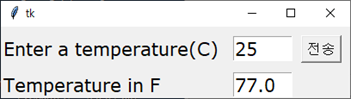

In [ ]:
#GUI_socket_client.py
# 섭씨 온도를 보내고 화씨 온도를 받아 표시하는 GUI 클라이언트 프로그램

from tkinter import *
from socket import *
import threading

#섭씨 온도를 서버로 전송하는 callback 함수
def calculate():
    global temp
    
    #섭씨 온도를 읽는다
    temp = float(entry1.get()) 
    #섭씨 온도를 서버로 전송
    sock.send(str(temp).encode()) 

In [ ]:
#Thread handler
def handler(sock):
    #화씨 온도를 받아 화씨 온도 창에 표시한다
    #반드시 무한루프로 실행해야 계속 동작할 수 있다
    while True:
        #데이터를 수신하여 화씨 온도 창에 표시
        try: #수신 데이터가 없으면 예외 발생
            r_msg = sock.recv(1024) #메시지 수신
        except: #수신 데이터 없음
            pass
        else: #수신 데이터 표시
            #화씨 온도 창을 지운다
            entry2.delete(0, END)
            #새로운 화씨 온도를 표시한다
            entry2.insert(0, r_msg.decode())
            #섭씨 온도 창을 지운다
            entry1.delete(0, END)

In [ ]:
sock = socket(AF_INET, SOCK_STREAM)
sock.connect(("localhost", 2500))

root = Tk()
#섭씨 온도 라벨과 입력 창
message_label = Label(text='Enter a temperature(C)  ',font=('Verdana', 16))
entry1 = Entry(font=('Verdana', 16), width=5)

#화씨 온도 라벨과 입력 창
recv_label = Label(text='Temperature in F  ',font=('Verdana', 16))
entry2 = Entry(font=('Verdana', 16), width=5)

#전송 버튼
calc_button = Button(text='전송', font=('Verdana', 12), command=calculate)

In [ ]:
#위젯 배치
message_label.grid(row=0, column=0, sticky=W)
recv_label.grid(row=1, column=0, sticky=W)
entry1.grid(row=0, column=1)
entry2.grid(row=1, column=1)
calc_button.grid(row=0, column=2, padx=10, pady=10)

#데이터 수신을 위한 스레드 생성과 실행
cThread = threading.Thread(target=handler, args=(sock,))
cThread.daemon = True
cThread.start()

mainloop()

**[실행 방법]**

서버(GUI_socket_server.py)를 먼저 실행하고, 클라이언트(GUI_socket_client.py)를 실행한다. GUI 화면에서 섭씨 온도를 입력하고 [전송] 버튼을 클릭하면 화씨 온도가 표시되는지 확인한다.

**[연습문제 12-3]**  

(1) 예제 클라이언트 프로그램은 함수로 구성되어 있다. 함수 사이에 변수를 공용하기 위해서는 공용할 변수(temp)를 global로 선언해야 한다. 그러나 프로그램을 클래스로 구성하면 메서드 사이의 공용되는 변수는 인스턴스 변수로 선언하면 되므로 편리하다. 예제 프로그램을 클래스를 이용하여 다시 작성해 보자.  
  
(2) 예제 서버 프로그램은 한 명의 클라이언트만 서비스할 수 있다. 두 명 이상의 클라이언트를 동시에 서비스할 수 있도록 프로그램을 수정해 보자. 서버 프로그램에서도 threading.Thread를 이용하여 다수의 클라이언트를 서비스할 수 있다.  

(3) 예제 서버 프로그램은 TCP를 이용하여 데이터를 송수신한다. UDP를 이용하여 유사한 기능을 하는 서버와 클라이언트 프로그램을 작성해 보자.

#### threading 모듈을 이용한 TCP 멀티 채팅 GUI 프로그램

다수의 클라이언트가 동시에 서버에 접속하여 메시지를 주고받는 GUI 채팅 프로그램  

**멀티 채팅 서버 프로그램**  
* 채팅 서버 프로그램은 클라이언트가 보내온 메시지를 다른 클라이언트에게 중계하여 클라이언트 끼리 채팅 가능
* 클래스를 정의하고 accept_client(0, receive_message(), send_all_clients() 메서드를 포함

```python
class ChatserverMulti:
    def __init__(self):
	      #소켓 생성
	      #연결 대기
	      #accept_client()를 호출하여 클라이언트와 연결

    #연결을 수락하고 서브 스레드를 생성하여 실행
    def accept_client(self):
      while True:
	      #연결 수락
	      #연결 소켓 추가
	      #메시지 수신 스레드 생성/실행(receive_message 함수)

    #메시지를 수신하고 모든 클라이언트에게 전송
    def receive_message(self, sock):
      while True:
	      #메시지 수신
	      #send_all_clients() 호출

    #발신자를 제외한 모든 연결 소켓으로 메시지 전송
    def send_all_clients(self, senders_socket):
	      
```

In [ ]:
#GUI_ChatServer_Multi.py
# threading 모듈을 이용한 TCP 멀티 채팅 서버 프로그램

from socket import *
from threading import *

class MultiChatServer:
    #소켓을 생성하고 연결되면 accept_client() 호출
    def __init__(self):
        #접속된 클라이언트 소켓 목록
        self.clients = [] 
        #최종 수신 메시지
        self.final_received_message = "" 
        
        #소켓을 생성하고 연결 요청 수락
        self.s_sock = socket(AF_INET, SOCK_STREAM)
        self.ip = ''
        self.port = 2500
        self.s_sock.setsockopt(SOL_SOCKET, SO_REUSEADDR, 1)
        self.s_sock.bind((self.ip, self.port))
        print("클라이언트 대기 중 ...")
        self.s_sock.listen(100)
        self.accept_client()
        

In [ ]:
    #클라이언트 소켓을 목록에 추가하고 스레드를 생성하여 데이터를 수신한다
    def accept_client(self):
        while True:
            #연결 수락
            client = c_socket, (ip, port) = self.s_sock.accept()
            
            #소켓 목록에 없으면 접속된 소켓을 목록에 추가
            if client not in self.clients:
                self.clients.append(client) 
            print (ip , ':' , str(port), ' 가 연결되었습니다')
            
            #접속 소켓을 위한 스레드 실행
            cth = Thread(target=self.receive_messages, args=(c_socket,)) #수신 스레드
            cth.start() #스레드 시작
            

In [ ]:
    #데이터를 수신하여 모든 클라이언트에게 전송한다
    def receive_messages(self, c_socket):
        while True:
            try:
                incoming_message = c_socket.recv(256)
                if not incoming_message: #연결이 종료됨
                    break
            except:
                continue
            else:
                self.final_received_message = incoming_message.decode('utf-8')
                print(self.final_received_message)
                #발신자를 제외한 클라이언트에게 전송
                self.send_all_clients(c_socket)
        c_socket.close()
        

In [ ]:
    #송신 클라이언트를 제외한 모든 클라이언트에게 메시지 전송
    def send_all_clients(self, senders_socket):
        for client in self.clients: #목록에 있는 클라이언트
            socket, (ip, port) = client
            
            #송신 클라이언트는 제외하고 전송
            if socket is not senders_socket: 
                try:
                    socket.sendall(self.final_received_message.encode('utf-8'))
                
                #전송 실패면 연결이 종료된 것이므로 목록에서 제거
                except: 
                   self.clients.remove(client) #소켓 제거
                   print("{}, {} 연결이 종료되었습니다".format(ip, port))
        
            
if __name__ == "__main__":
    MultiChatServer()

**GUI 채팅 클라이언트 프로그램**  

* GUI 환경에서 전송 데이터와 수신 데이터를 표시  
* 서용자 이름 입력창, 송신 메시지 입력창, 수신 메시지 출력 창, [전송] 버튼을 클래스로 구현

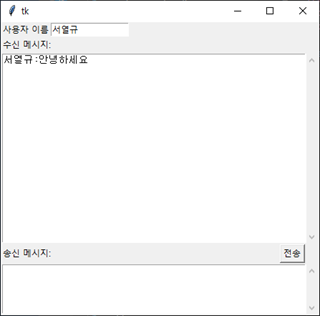

* ChatClient 클래스의 메서드  
  * initialize_socket()  
    소켓을 생성하고 서버로 연결  
  * initialize_gui()  
    5개의 프레임을 이용하여 사용자 화면 구성  
    * 프레임 1: 사용자 이름 라벨(name_label) + 이름 입력 창(name_widget, Entry)  
    * 프레임 2: 수신 메시지 라벨(recv_label)  
    * 프레임 3: 수신 메시지 창(chat_transcript_area, ScrolledText)  
    * 프레임 4: 송신 메시지 라벨(send_label) + [송신] 버튼(send_btn, Button)  
    * 프레임 5: 송신 메시지 창(enter_text_widget, ScrolledText)
  * send_chat()  
    송신 메시지 창에서 메시지를 읽어 수신 메시지 창에 표시  
  * receive_message()  
    소켓에서 메시지를 읽어 수신 메시지 창에 표시  
  * listen_thread()  
    receive_message()를 실행하는 스레드

In [ ]:
#GUI_chatclient.py
# GUI 채팅 클라이언트

from socket import *
from tkinter import *
from tkinter.scrolledtext import ScrolledText
from threading import *

class ChatClient:
    client_socket = None
    
    def __init__(self, ip, port):
        self.initialize_socket(ip, port)
        self.initialize_gui()
        self.listen_thread()
        
    #TCP socket을 생성하고 server에게 연결
    def initialize_socket(self, ip, port):
        self.client_socket = socket(AF_INET, SOCK_STREAM)
        remote_ip = ip
        remote_port = port
        self.client_socket.connect((remote_ip, remote_port))
        

In [ ]:
    #message를 전송하는 callback 함수
    def send_chat(self):
        #송신자 이름
        senders_name = self.name_widget.get().strip() + ":"
        #송신 메시지 창에서 메시지를 읽어 온다
        data = self.enter_text_widget.get(1.0, 'end').strip()
        #송신자 이름과 메시지를 결합
        message = (senders_name + data).encode('utf-8')
        #전송 메시지를 자신의 수신 메시지 창에도 표시
        self.chat_transcript_area.insert('end',
                        message.decode('utf-8') + '\n')
        self.chat_transcript_area.yview(END)
        #메시지 전송
        self.client_socket.send(message)
        #송신 메시지 창을 비운다
        self.enter_text_widget.delete(1.0, 'end')
        return 'break'        
        

In [ ]:
    #위젯을 배치하고 초기화한다
    def initialize_gui(self):
        self.root = Tk()
        fr = []
        #5개의 프레임 생성
        for i in range(0,5):
            fr.append(Frame(self.root))
            fr[i].pack(fill=BOTH)
                
        #화면 라벨
        self.name_label = Label(fr[0], text='사용자 이름')
        self.recv_label = Label(fr[1], text = '수신 메시지:')
        self.send_label = Label(fr[3], text = '송신 메시지:')
        #[전송] 버튼
        self.send_btn = Button(fr[3], text='전송', command=self.send_chat)
        #수신 메시지 창
        self.chat_transcript_area = ScrolledText(fr[2], height =20, width=60)
        #송신 메시지 창
        self.enter_text_widget = ScrolledText(fr[4], height =5, width=60)
        #사용자 이름 입력 창
        self.name_widget = Entry(fr[0], width =15)
      
        #위젯 배치
        self.name_label.pack(side=LEFT)
        self.name_widget.pack(side=LEFT)
        self.recv_label.pack(side=LEFT)
        self.send_btn.pack(side=RIGHT, padx=20)
        self.chat_transcript_area.pack(side=LEFT, padx=2, pady=2)
        self.send_label.pack(side=LEFT)
        self.enter_text_widget.pack(side=LEFT, padx=2, pady=2)
        

In [ ]:
    #Thread를 생성하고 채팅을 시작한다
    def listen_thread(self):
        t = Thread(target=self.receive_message, args=(self.client_socket,))
        t.start()
        
    #Server로부터 message를 수신하고 수신 메시지 창에 표시한다
    def receive_message(self, so):
        while True:
            buf = so.recv(256)
            if not buf:
                break
            #수신 메시지 창에 표시
            self.chat_transcript_area.insert('end',buf.decode('utf-8') + '\n')
            #화면을 아래로 이동
            self.chat_transcript_area.yview(END)
        so.close()
        
if __name__ == "__main__":
    ip = input("server IP addr: ")
    if ip == '':
        ip = '127.0.0.1'    
    port = 2500
    ChatClient(ip, port)
    mainloop()

**[실행 방법]**  
서버 프로그램(GUI_ChatServer_Multi.py)을 먼저 실행하고 클라이언트 프로그램(GUI_chatclient.py)을 실행한다. 사용자 이름과 전송 메시지를 송신 메시지창에 입력한 다음, [전송] 버튼을 클릭하면 메시지가 서버로 송신된다. 메시지 앞에는 사용자 이름이 추가되어 전송된다. 서버로부터 수신된 메시지는 수신 메시지창에 표시된다.

**[연습문제 12-4]**  
사용자 이름 오른쪽에 서버주소 및 포트 번호 입력 창과 [연결] 버튼을 추가하여 서버 주소를 사용자가 설정할 수 있도록 클라이언트 프로그램을 수정하시오. 서버 주소와 포트 번호를 입력하고 [연결] 버튼을 클릭하여 서버와 연결한다.

#### threading 모듈을 이용한 UDP 채팅 프로그램

**UDP 채팅 서버**  
+ 수신 메시지를 발신자를 제외한 다른 클라이언트에게 보낸다. 
+ 상대방이 “quit” 메시지를 전송하면 채팅을 종료한다.  
+ 연결이 종료되었을 때 recvfrom()을 호출하면 예외가 발생할 수 있으므로 recvfrom()은 try-except 구문 속에 포함되어야 한다

In [ ]:
#threading_UDP_chatserver.py
# UDP 채팅 서버 프로그램

import socket
import time

host = ''
port = 2500

#접속 클라이언트 리스트
clients = [] 

s = socket.socket(socket.AF_INET, socket.SOCK_DGRAM)
s.bind((host, port))
#넌블로킹 모드
s.setblocking(0)

print('Server Started')

In [ ]:
#클라이언트 메시지를 받아 모든 사용자에게 전송하고 소켓 목록 관리
while True:
    try:
        data, addr = s.recvfrom(1024)
        #"quit"가 수신되면 목록에서 제외
        if "quit" in data.decode():
            if addr in clients:
                clients.remove(addr)
                print(f'{addr}가 떠났습니다')
                
        #상대방이 클라이언트 리스트에 없으면 추가
        if addr not in clients: 
            print("new client")
            clients.append(addr)
        #시간+상대방주소+메시지 출력
        print(time.ctime(time.time()) + str(addr) + ': :' + data.decode())
        
        #발신자를 제외한 모든 클라이언트에게 전송
        for client in clients: 
            if client != addr:
                s.sendto(data, client)
    except:
        pass
s.close()

**UDP 채팅 클라이언트**  

송신 메시지를 입력받아 전송하고 수신 메시지는 화면에 표시  
* 메시지를 수신하여 화면에 출력하는 기능을 스레드로 작성하여 실행하면 송신 메시지 입력 중이라도 수신 메시지를 표시 가능

In [ ]:
#threading_UDP_client.py
# threading 모듈을 이용한 UDP 클라이언트 프로그램
# 데이터 수신은 스레드로 실행하고 송신은 무한 루프로 실행

import socket
import threading

#스레드로 실행할 함수
#데이터를 수신하여 화면에 표시
def handler(sock): 
    while True: #데이터 수
        try:
            msg, addr = sock.recvfrom(1024)
        except: #수신 데이터가 없으면 다시 시도
            continue
        else: #수신 메시지가 있으면 출력
            print(msg.decode())

#서버 주소를 설정하고 소켓 생성
conn = ('localhost', 2500)
svr = socket.socket(socket.AF_INET, socket.SOCK_DGRAM)

my_id = input("ID를 입력하세요: ")

#스레드를 생성하고 시작
cThread = threading.Thread(target=handler, args=(svr,)) #스레드 생성
cThread.daemon = True
cThread.start() #스레드 시작

#자신의 메시지를 ID와 함께 송신
while True:
    msg = '['+my_id+'] '+input()
    svr.sendto(msg.encode(), conn)

**[실행 방법]**  
서버 프로그램(threading_UDP_chatserver.py)을 먼저 실행하고 위의 클라이언트 프로그램을 두 개 이상 실행한다. 임의의 클라이언트가 전송한 메시지를 다른 모든 클라이언트가 수신하는지 확인한다.

**[연습문제 12-5]**  
TCP 소켓을 이용한 GUI  채팅 클라이언트 프로그램(GUI_chatclient.py)를 참고하여 UDP 소켓을 이용한 GUI 채팅 프로그램을 작성하라. 화면 구성은 TCP 프로그램과 동일하게 하고 서버는 threading_udp_chatserver.py를 사용하라.  
(연습문제_12-5_답안.py)

### concurrent.future 모듈을 이용한 멀티 에코 프로그램

concurrent.futures 모듈의 ThreadPoolExecutor 클래스를 이용하여 멀티스레드를 구현한다  
+ ThreadPoolExecutor 클래스는 스레드 풀(Thread Pool)에 등록된 함수를 비동기적으로 실행하는 Executor 클래스의 서브 클래스이다
+ Executor의 submit() 메서드를 이용하여 실행 함수를 스레드 풀에 등록
+ submit() 메서드로 등록된 함수는 스레드로 실행  

```python
import concurrent.futures as cf
➊ def receive_message(sock, addr): #스레드로 실행할 함수
.........

➋ with cf.ThreadPoolExecutor(max_workers=10) as th #스레드 풀 생성
➌    th.submit(receive_message, sock, addr) #실행 함수를 스레드 풀에 등록
```

**멀티 에코 서버 프로그램**  

다수의 클라이언트를 서비스하는 에코 서버 프로그램  
* receive_message(sock, address)
  * 메시지를 수신하여 화면에 출력하고 다시 전송하는 함수
  * 무한 루프로 실행되며, 연결이 해제되면 종료
* 메인 함수
  * 최대 스레드 수(max_works)를 10으로 설정하여 스레드 풀을 생성
  * 클라이언트 연결을 수락하고 처리 함수(receive_message)를 스레드 풀에 등록
  * 등록된 처리 함수는 스레드에 의해 계속 서비스 된다

In [ ]:
#future_socket_server.py
# concurrent.futures 모듈을 이용한 멀티 에코 서버 프로그램

import concurrent.futures as cf
from socket import *

In [ ]:
#메시지를 수신하여 화면에 출력하고 다시 전송하는 무한 루프 함수
def receive_message(sock, address):
    while True:
        try:
            r_msg = sock.recv(1024) #메시지 수신
            if not r_msg: #상대방이 연결을 해제함
                break
            print('수신 메시지: ', r_msg.decode())
            sock.sendall(r_msg) #에코
            print('송신 메시지: ', r_msg.decode())
        #강제로 연결이 해제되면 실행 종료
        except: 
            break
    sock.close()

In [ ]:
s_sock = socket(AF_INET, SOCK_STREAM)
s_sock.setsockopt(SOL_SOCKET, SO_REUSEADDR, 1)
s_sock.bind(('', 2500))
s_sock.listen(5)
print('{}에서 연결 대기 중'.format(s_sock.getsockname()))

#스레드 풀을 생성하고 함수를 등록한다
with cf.ThreadPoolExecutor(max_workers=10) as th: #max_workers: 최대 스레드 수
    try:
        while True: #다중 접속을 받는다
            c_sock, addr = s_sock.accept()
            print("Connectionn from", addr)
            #처리 함수를 스레드 풀에 등록한다
            th.submit(receive_message, c_sock, addr) 
    except: #예외가 발생하면 종료한다
        pass
    finally:
        s_sock.close()

**[실행 방법]**  
서버 프로그램을 먼저 실행하고 클라이언트 프로그램(TCP_client.py)을 실행한다. 클라이언트를 하나 더 실행하고 결과를 확인해 보자.

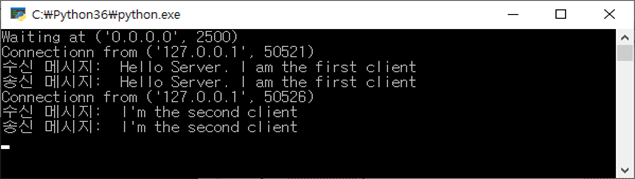

## 멀티프로세스 서버 프로그램

멀티스레드는 단일 프로세스로 실행되며 코드, 데이터, 힙(heap) 메모리를 공유하지만, 멀티프로세스 프로그램에서 각 프로세스는 각자의 메모리 영역을 가진다  
* 멀티프로세스 장점
  * CPU 코어를 최대로 활용하여 처리 속도가 빠르다
* 멀티프로세스 단점  
  * 프로세스마다 별도 자원을 가지므로 프로세스를 스위칭할 때 상당한 부담이 발생

**멀티프로세스를 이용한 TCP 에코 서버 프로그램**  
  
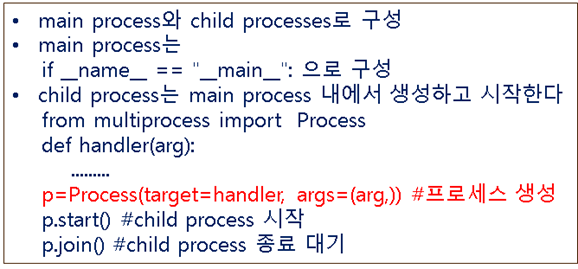

In [ ]:
#multiprocess_TCP_server.py
# multiprocessing 모듈을 이용한 TCP 서버 프로그램

from socket import socket
from multiprocessing import Process

#자식 프로세스로 실행할 함수
#문자를 수신하여 화면 출력하고 다시 전송
def handle(sock): 
    while True:
        msg = sock.recv(1024)
        print(f'Received message: {msg.decode()}')
        sock.send(msg)
    

In [ ]:
#main process
if __name__ == "__main__":
    sock = socket()
    addr = ('', 2500)
    sock.bind(addr)
    sock.listen(4)
    
    while True:
        c_sock, r_addr = sock.accept()
        print(f'{r_addr} is connected')
        
        #자식프로세스 생성
        p1 = Process(target=handle, args=(c_sock,)) 
        p1.start() #자식 프로세스 시작
        p1.join()

**[실행 방법]**  
서버 프로그램(multiprocess_TCP_server.py)을 먼저 실행하고 클라이언트 프로그램(TCP_client.py)를 두 번 이상 실행한다. 각각의 클라이언트가 보낸 메시지를 다시 수신하는지 확인해 보자.

**[연습문제 12-6]**  
multiprocess_TCP_server.py 프로그램을 수정하여 “Hello”를 수신하면 새로운 프로세스를 생성하여 “Hello Client”를 전송하고 “Good”을 수신하면 또 다른 프로세스를 생성하여 “Good Afternoon” 메시지를 송신하는 프로그램을 작성하시오.